# Classification Modeling - Update

# Imports

In [1]:
from joblib import parallel_backend
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Import modeling tools, pipelines, models, and metrics

from sklearnex import patch_sklearn
patch_sklearn()

import shap

from sklearn import metrics, set_config
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler

set_config(transform_output='pandas')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Select Features

In [2]:
filepath = '../../data/column_groups.json'
with open(filepath, 'r') as file:
    data = json.load(file)
    
for k, v in data.items():
    print(k, v)

booking_details ['UUID', 'HotelNumber', 'Adults', 'Children', 'Babies', 'Country', 'MarketSegment', 'DistributionChannel', 'ReservedRoomType', 'DepositType', 'Agent', 'Company', 'CustomerType', 'ADR']
post_stay_details ['UUID', 'AssignedRoomType', 'BookingChanges', 'DaysInWaitingList', 'RequiredCarParkingSpaces', 'ReservationStatus']
reservation_specific ['UUID', 'Meal', 'IsRepeatedGuest', 'PreviousCancellations', 'PreviousBookingsNotCanceled']
temporal_features ['UUID', 'LeadTime', 'ArrivalDateYear', 'ArrivalDateMonth', 'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth', 'StaysInWeekendNights', 'StaysInWeekNights', 'ReservationStatusDate']
new_temporal_features ['ArrivalDateDayName', 'ArrivalDateMonthName', 'ArrivalDate_DaysAfterHoliday', 'ArrivalDate_DaysBeforeHoliday', 'ArrivalDay', 'ArrivalWeek', 'BookingDate_DaysAfterHoliday', 'BookingDate_DaysBeforeHoliday', 'DaysSinceBooking', 'DepartureDate_DaysAfterHoliday', 'DepartureDate_DaysBeforeHoliday', 'Length of Stay']


In [3]:
selected_features = data['booking_details']
selected_features.extend(data['post_stay_details'])
selected_features.extend(data['new_temporal_features'])

selected_features = set(selected_features)
selected_features.remove('UUID')
selected_features.remove('ADR')
selected_features.remove('AssignedRoomType')
selected_features.remove('RequiredCarParkingSpaces')

selected_features = list(selected_features)
selected_features.sort()

In [4]:
selected_features

['Adults',
 'Agent',
 'ArrivalDateDayName',
 'ArrivalDateMonthName',
 'ArrivalDate_DaysAfterHoliday',
 'ArrivalDate_DaysBeforeHoliday',
 'ArrivalDay',
 'ArrivalWeek',
 'Babies',
 'BookingChanges',
 'BookingDate_DaysAfterHoliday',
 'BookingDate_DaysBeforeHoliday',
 'Children',
 'Company',
 'Country',
 'CustomerType',
 'DaysInWaitingList',
 'DaysSinceBooking',
 'DepartureDate_DaysAfterHoliday',
 'DepartureDate_DaysBeforeHoliday',
 'DepositType',
 'DistributionChannel',
 'HotelNumber',
 'Length of Stay',
 'MarketSegment',
 'ReservationStatus',
 'ReservedRoomType']

# Load Data

In [5]:
df_data = pd.read_feather('../../data/3.2_data_with_occupancies.feather', columns=selected_features)
df_data

,Adults,Children,Babies,Country,MarketSegment,DistributionChannel,ReservedRoomType,BookingChanges,DepositType,Agent,...,ArrivalDate_DaysBeforeHoliday,ArrivalDate_DaysAfterHoliday,DepartureDate_DaysBeforeHoliday,DepartureDate_DaysAfterHoliday,BookingDate_DaysBeforeHoliday,BookingDate_DaysAfterHoliday,ArrivalWeek,ArrivalDay,ArrivalDateDayName,ArrivalDateMonthName
0,2,0.0,0,PRT,Direct,Direct,C,3,No Deposit,NULL,...,45,21,45,21,22,44,27,3,Wednesday,July
1,2,1.0,0,IRL,Offline TA/TO,TA/TO,A,0,No Deposit,156,...,45,21,38,28,60,32,27,3,Wednesday,July
2,2,0.0,0,IRL,Offline TA/TO,TA/TO,A,0,No Deposit,156,...,45,21,38,28,60,32,27,3,Wednesday,July
3,2,0.0,0,GBR,Offline TA/TO,TA/TO,A,0,No Deposit,115,...,45,21,38,28,56,36,27,3,Wednesday,July
4,3,0.0,0,ESP,Offline TA/TO,TA/TO,A,2,No Deposit,6,...,45,21,40,26,21,71,27,3,Wednesday,July
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,2,0.0,0,FRA,Online TA,TA/TO,A,0,No Deposit,9,...,35,16,32,19,39,12,35,4,Thursday,August
119386,2,0.0,0,GBR,Online TA,TA/TO,A,0,No Deposit,9,...,35,16,33,18,59,44,35,4,Thursday,August
119387,2,0.0,0,GBR,Online TA,TA/TO,D,4,No Deposit,9,...,35,16,33,18,2,49,35,4,Thursday,August
119388,2,0.0,0,GBR,Online TA,TA/TO,A,0,No Deposit,89,...,35,16,28,23,27,13,35,4,Thursday,August


In [6]:
df_data[selected_features]

,Adults,Agent,ArrivalDateDayName,ArrivalDateMonthName,ArrivalDate_DaysAfterHoliday,ArrivalDate_DaysBeforeHoliday,ArrivalDay,ArrivalWeek,Babies,BookingChanges,...,DaysSinceBooking,DepartureDate_DaysAfterHoliday,DepartureDate_DaysBeforeHoliday,DepositType,DistributionChannel,HotelNumber,Length of Stay,MarketSegment,ReservationStatus,ReservedRoomType
0,2,NULL,Wednesday,July,21,45,3,27,0,3,...,342,21,45,No Deposit,Direct,H1,0,Direct,Check-Out,C
1,2,156,Wednesday,July,21,45,3,27,0,0,...,156,28,38,No Deposit,TA/TO,H1,7,Offline TA/TO,Check-Out,A
2,2,156,Wednesday,July,21,45,3,27,0,0,...,156,28,38,No Deposit,TA/TO,H1,7,Offline TA/TO,Check-Out,A
3,2,115,Wednesday,July,21,45,3,27,0,0,...,152,28,38,No Deposit,TA/TO,H1,7,Offline TA/TO,Check-Out,A
4,3,6,Wednesday,July,21,45,3,27,0,2,...,115,26,40,No Deposit,TA/TO,H1,5,Offline TA/TO,Check-Out,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,2,9,Thursday,August,16,35,4,35,0,0,...,7,19,32,No Deposit,TA/TO,H2,3,Online TA,Check-Out,A
119386,2,9,Thursday,August,16,35,4,35,0,0,...,200,18,33,No Deposit,TA/TO,H2,2,Online TA,Check-Out,A
119387,2,9,Thursday,August,16,35,4,35,0,4,...,334,18,33,No Deposit,TA/TO,H2,2,Online TA,Check-Out,D
119388,2,89,Thursday,August,16,35,4,35,0,0,...,116,23,28,No Deposit,TA/TO,H2,7,Online TA,Check-Out,A


## Transform Target

In [7]:
df_data.loc[:, 'ReservationStatus'] = np.where(df_data['ReservationStatus'] == 'No-Show',
                                               'Canceled',
                                               df_data['ReservationStatus'])
df_data['ReservationStatus'].value_counts(normalize=True).round(2)

ReservationStatus
Check-Out    0.63
Canceled     0.37
Name: proportion, dtype: float64

# Train/Test Split

In [8]:
target_feature = 'ReservationStatus'

X = df_data.loc[:, selected_features].drop(columns=target_feature)
y = df_data[target_feature]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state = 42,
                                                    stratify=y)

In [9]:
y_train.value_counts(normalize=True).round(2)

ReservationStatus
Check-Out    0.63
Canceled     0.37
Name: proportion, dtype: float64

In [10]:
y_test.value_counts(normalize=True).round(2)

ReservationStatus
Check-Out    0.63
Canceled     0.37
Name: proportion, dtype: float64

# Random Forest Classifer Model Without Tuning

In [11]:
# Select categorical and numerical features
cat_feats = X.select_dtypes(include=['object']).columns
num_feats = X.select_dtypes(include=['number']).columns

## --- Create separate pipelines for categorical and numeric features --- ##

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='infrequent_if_exist',
                              sparse_output=False,
                              max_categories=200))])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))])

## --- Combine transformers into a single ColumnTransformer --- ##
preprocessor = ColumnTransformer(transformers=[('num', num_pipeline, num_feats),
                                               ('cat', cat_pipeline, cat_feats)])

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 Index(['Adults', 'ArrivalDate_DaysAfterHoliday',
       'ArrivalDate_DaysBeforeHoliday', 'ArrivalDay', 'ArrivalWeek', 'Babies',
       'BookingChanges', 'BookingDate_DaysAfterHoliday',
       'BookingDate_DaysBeforeHoliday', 'Children', 'DaysInWaitingList',
       'DaysSinceBooking', 'De...
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                max_categories=200,
                                                                sparse_output=False))]),
                                 Index(['Agent', 'Company', 'Country', 'CustomerType', 'DepositType',
       'DistributionChannel', 'HotelNumber', 'MarketSegment',
       'ReservedRoomType'],
      dtype='object'))])

In [12]:
X_train_xf = preprocessor.fit_transform(X_train)
X_train_xf

,num__Adults,num__ArrivalDate_DaysAfterHoliday,num__ArrivalDate_DaysBeforeHoliday,num__ArrivalDay,num__ArrivalWeek,num__Babies,num__BookingChanges,num__BookingDate_DaysAfterHoliday,num__BookingDate_DaysBeforeHoliday,num__Children,...,cat__ReservedRoomType_A,cat__ReservedRoomType_B,cat__ReservedRoomType_C,cat__ReservedRoomType_D,cat__ReservedRoomType_E,cat__ReservedRoomType_F,cat__ReservedRoomType_G,cat__ReservedRoomType_H,cat__ReservedRoomType_L,cat__ReservedRoomType_P
97160,1.0,61.0,42.0,5.0,9.0,0.0,0.0,44.0,59.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72545,2.0,28.0,38.0,5.0,27.0,0.0,0.0,25.0,41.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25753,2.0,4.0,3.0,1.0,49.0,0.0,0.0,20.0,10.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52288,2.0,112.0,3.0,6.0,49.0,0.0,0.0,63.0,52.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28348,2.0,34.0,69.0,6.0,5.0,0.0,0.0,15.0,15.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56864,1.0,54.0,30.0,3.0,8.0,0.0,0.0,49.0,35.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45645,2.0,33.0,82.0,4.0,38.0,0.0,0.0,64.0,28.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94618,2.0,34.0,69.0,6.0,5.0,0.0,0.0,20.0,10.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
118977,2.0,12.0,39.0,7.0,34.0,0.0,0.0,3.0,48.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
for col in X_train_xf.columns:
    print(col)

num__Adults
num__ArrivalDate_DaysAfterHoliday
num__ArrivalDate_DaysBeforeHoliday
num__ArrivalDay
num__ArrivalWeek
num__Babies
num__BookingChanges
num__BookingDate_DaysAfterHoliday
num__BookingDate_DaysBeforeHoliday
num__Children
num__DaysInWaitingList
num__DaysSinceBooking
num__DepartureDate_DaysAfterHoliday
num__DepartureDate_DaysBeforeHoliday
num__Length of Stay
cat__Agent_          1
cat__Agent_          2
cat__Agent_          3
cat__Agent_          4
cat__Agent_          5
cat__Agent_          6
cat__Agent_          7
cat__Agent_          8
cat__Agent_          9
cat__Agent_         10
cat__Agent_         11
cat__Agent_         12
cat__Agent_         13
cat__Agent_         14
cat__Agent_         15
cat__Agent_         16
cat__Agent_         17
cat__Agent_         19
cat__Agent_         20
cat__Agent_         21
cat__Agent_         22
cat__Agent_         23
cat__Agent_         24
cat__Agent_         26
cat__Agent_         27
cat__Agent_         28
cat__Agent_         29
cat__Agent_ 

In [14]:
## --- Build the full pipeline --- ##
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', RandomForestClassifier(class_weight='balanced'))])

# Use joblib for parallel processing
with parallel_backend('loky', n_jobs=-1):

    ## --- Fit the model and generate predictions --- ##
    model_pipeline.fit(X_train, y_train)

y_pred = model_pipeline.predict(X_test)

## --- Evaluate performance metrics --- ##
# score_training = model_pipeline.score(X_train, y_train)
# score_testing = model_pipeline.score(X_test, y_test)

## Model Results

### Scoring

In [15]:
def classification_results(model_pipeline, X_train, X_test, y_train, y_test):
    
    y_train_pred = model_pipeline.predict(X_train)
    y_test_pred = model_pipeline.predict(X_test)
    
    score_training = metrics.f1_score(y_train, y_train_pred, average='weighted')
    score_testing = metrics.f1_score(y_test, y_test_pred, average='weighted')

    print(f'\nTraining Score: {score_training:,.3f}\n'
        f'Testing Score: {score_testing:,.3f}\n'
        f'Difference: {score_training - score_testing:,.3f}\n')

    print(classification_report(y_test, y_test_pred))

    ConfusionMatrixDisplay.from_predictions(y_test,
                                            y_test_pred,
                                            cmap='Blues',
                                            normalize='true')
    return None


Training Score: 1.000
Testing Score: 0.905
Difference: 0.095

              precision    recall  f1-score   support

    Canceled       0.93      0.81      0.86     11056
   Check-Out       0.89      0.97      0.93     18792

    accuracy                           0.91     29848
   macro avg       0.91      0.89      0.90     29848
weighted avg       0.91      0.91      0.90     29848



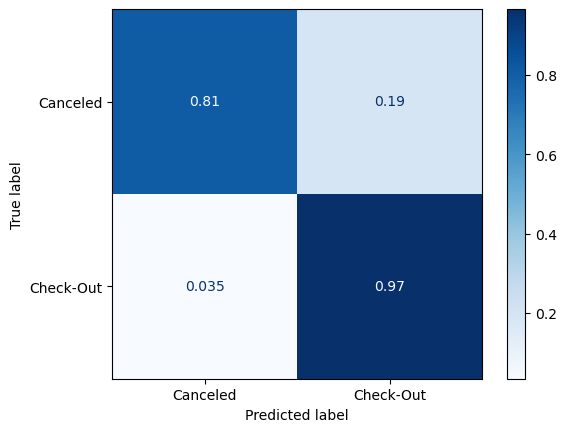

In [16]:
classification_results(model_pipeline = model_pipeline,
                       X_train = X_train,
                       X_test = X_test,
                       y_train = y_train,
                       y_test = y_test);

### Permutation Importances

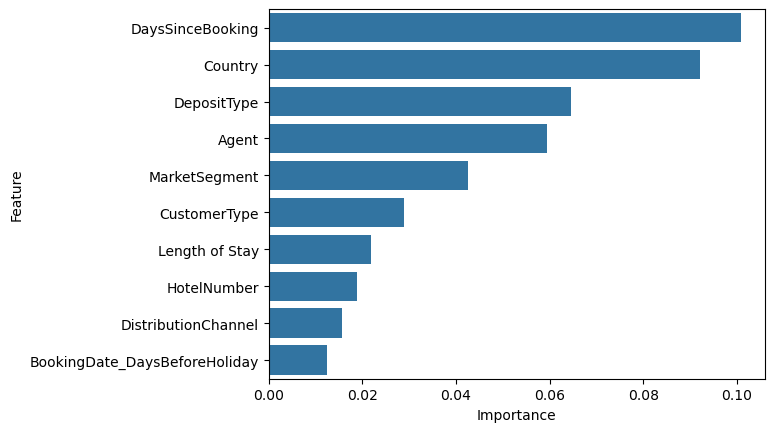

In [17]:
# Calculate permutation importances
result = permutation_importance(model_pipeline,
                                X_test, 
                                y_test,
                                n_jobs=-1,
                                scoring = 'f1_weighted')

# Extract importances and standard deviations
perm_importances = result.importances_mean
perm_importances_std = result.importances_std

# Create a DataFrame for easy plotting
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importances,
    'Importance_std': perm_importances_std
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Plot the feature importances
sns.barplot(x='Importance', y='Feature',data=importance_df[:10]);

### Tree Depths

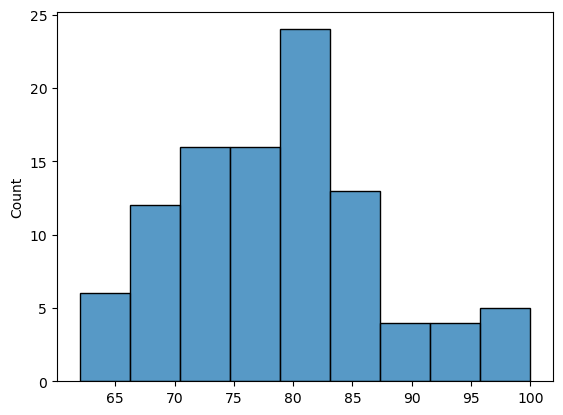

In [18]:
depths = [tree.get_depth() for tree in model_pipeline[-1].estimators_]

sns.histplot(depths);

# Random Forest Classifer Model with Tuning

In [19]:
# Select categorical and numerical features
cat_feats = X.select_dtypes(include=['object']).columns
num_feats = X.select_dtypes(include=['number']).columns

## --- Create separate pipelines for categorical and numeric features --- ##

# Update the categorical pipeline to use OneHotEncoder
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='infrequent_if_exist',
                              sparse_output=False,
                              max_categories=200))
])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

## --- Combine transformers into a single ColumnTransformer --- ##
preprocessor = ColumnTransformer(transformers=[('num', num_pipeline, num_feats),
                                               ('cat', cat_pipeline, cat_feats)])


# Create the RandomForestClassifier model
classifier = RandomForestClassifier(class_weight='balanced')

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

# Set up hyperparameter tuning with HalvingGridSearchCV
param_grid = {
    'classifier__max_depth': [25,50,75]}

# Set up Stratified K-Fold
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=False)

# Use joblib for parallel processing
with parallel_backend('loky', n_jobs=-1):
    
    grid_search = GridSearchCV(model_pipeline,
                               param_grid,
                               scoring='f1_weighted',
                               cv=stratified_kfold)

    # Fit the model and generate predictions
    grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

# Evaluate performance metrics
score_training = best_model.score(X_train, y_train)
score_testing = best_model.score(X_test, y_test)

## RFC Model w/ Tuning Results

### Scoring


Training Score: 1.000
Testing Score: 0.905
Difference: 0.095

              precision    recall  f1-score   support

    Canceled       0.94      0.80      0.87     11056
   Check-Out       0.89      0.97      0.93     18792

    accuracy                           0.91     29848
   macro avg       0.91      0.89      0.90     29848
weighted avg       0.91      0.91      0.91     29848



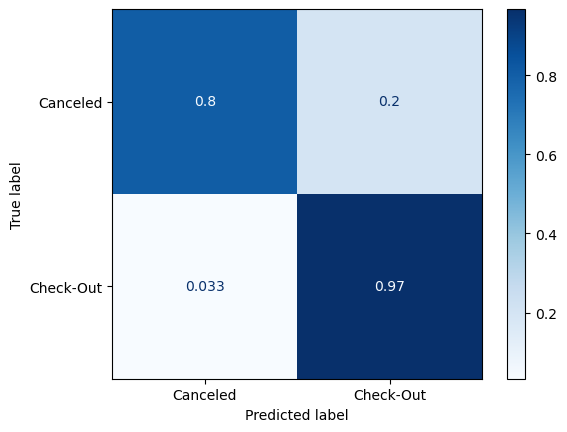

In [20]:
classification_results(model_pipeline = best_model,
                       X_train = X_train,
                       X_test = X_test,
                       y_train = y_train,
                       y_test = y_test);

### Permutation Importances

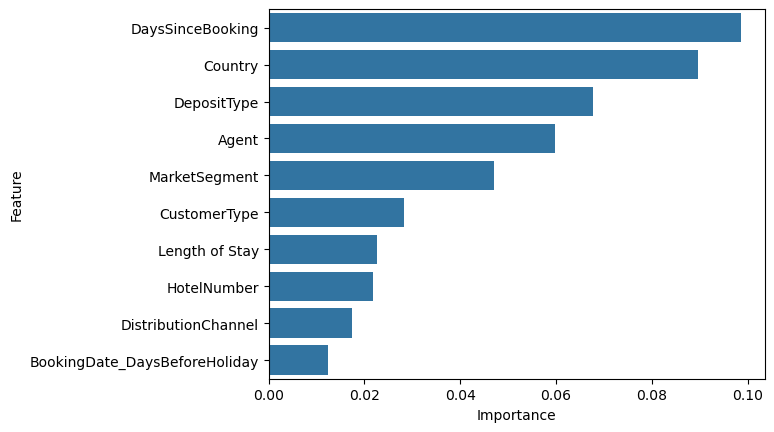

In [21]:
# Calculate permutation importances
result = permutation_importance(best_model,
                                X_test, 
                                y_test,
                                n_jobs=-1,
                                scoring = 'f1_weighted')

# Extract importances and standard deviations
perm_importances = result.importances_mean
perm_importances_std = result.importances_std

# Create a DataFrame for easy plotting
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importances,
    'Importance_std': perm_importances_std
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Plot the feature importances
sns.barplot(x='Importance', y='Feature',data=importance_df[:10]);

## SHAP - RFC

In [22]:
X_train_xf = best_model.named_steps.preprocessor.fit_transform(X_train)
X_test_xf = best_model.named_steps.preprocessor.transform(X_test)

In [23]:
X_shap_train = shap.sample(X_train_xf, 500)
y_shap_train = y_train.loc[X_shap_train.index]

X_shap_test = shap.sample(X_test_xf, 500)
y_shap_test = y_test.loc[X_shap_test.index]

In [24]:
explainer = shap.Explainer(best_model.named_steps.classifier, X_shap_train)
# shap_values_train = explainer(X_shap_train)
shap_values_test = explainer(X_shap_test)

 99%|===================| 992/1000 [01:56<00:00]        

In [25]:
# print(shap_values_train.shape)
print(shap_values_test.shape)

(500, 613, 2)


### Summary Plot

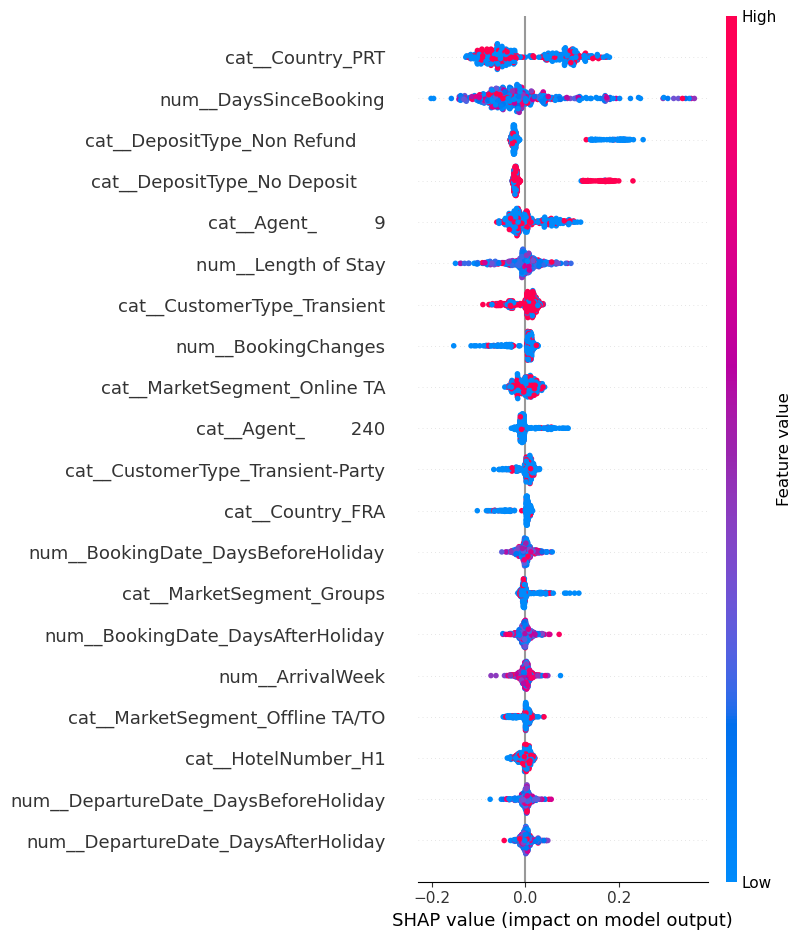

In [26]:
shap.summary_plot(shap_values_test[:, :, 0], X_shap_train)

In [27]:
# df_data.groupby(['Country'])[['ReservationStatus']].value_counts(normalize=True).loc['PRT']

### Force Plot

In [28]:
# For multiple predictions
# shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

# `HistGradientBoostingClassifier` Approach

In [40]:
# Select categorical and numerical features
cat_feats = X.select_dtypes(include=['object']).columns
num_feats = X.select_dtypes(include=['number']).columns

## --- Create separate pipelines for categorical and numeric features --- ##

# Create separate pipelines for categorical and numeric features
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='infrequent_if_exist',
                              sparse_output=False,
                              max_categories=200))
])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    # ('yeojohnson', PowerTransformer(method='yeo-johnson')),
    # ('scaler', StandardScaler())
])

# Combine transformers into a single ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_feats),
    ('cat', cat_pipeline, cat_feats)
])

# Create the RandomForestClassifier model
classifier = HistGradientBoostingClassifier(class_weight='balanced',
                                            scoring = 'f1_weighted')

hgbr_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

# Use joblib for parallel processing
with parallel_backend('loky', n_jobs=-1):
    
    # Fit the model and generate predictions
    hgbr_model_pipeline.fit(X_train, y_train)

hgbr_y_pred = hgbr_model_pipeline.predict(X_test)

# Evaluate performance metrics
hgbr_score_training = hgbr_model_pipeline.score(X_train, y_train)
hgbr_score_testing = hgbr_model_pipeline.score(X_test, y_test)


Training Score: 0.897
Testing Score: 0.887
Difference: 0.010

              precision    recall  f1-score   support

    Canceled       0.85      0.84      0.85     11056
   Check-Out       0.91      0.92      0.91     18792

    accuracy                           0.89     29848
   macro avg       0.88      0.88      0.88     29848
weighted avg       0.89      0.89      0.89     29848



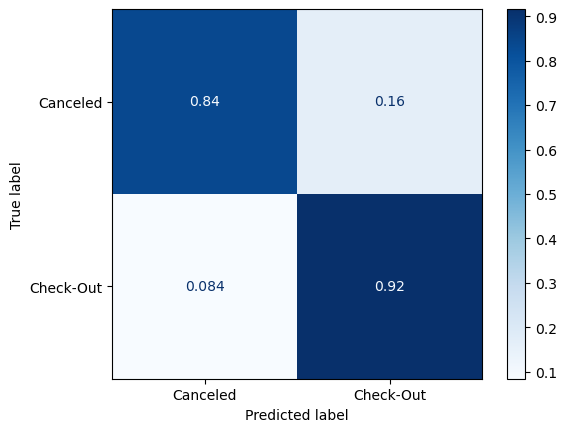

In [41]:
classification_results(model_pipeline = hgbr_model_pipeline,
                       X_train = X_train,
                       X_test = X_test,
                       y_train = y_train,
                       y_test = y_test);

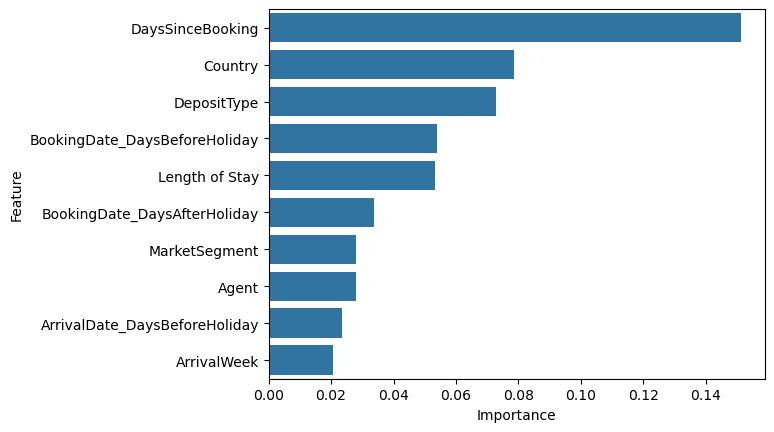

In [31]:
# Calculate permutation importances
result = permutation_importance(hgbr_model_pipeline,X_test, y_test,n_jobs=-1)

# Extract importances and standard deviations
perm_importances = result.importances_mean
perm_importances_std = result.importances_std

# Create a DataFrame for easy plotting
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importances,
    'Importance_std': perm_importances_std
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Plot the feature importances
sns.barplot(x='Importance', y='Feature',data=importance_df[:10]);

## SHAP - HGBR

In [32]:
X_train_xf = hgbr_model_pipeline.named_steps.preprocessor.fit_transform(X_train)
X_train_xf

,num__Adults,num__ArrivalDate_DaysAfterHoliday,num__ArrivalDate_DaysBeforeHoliday,num__ArrivalDay,num__ArrivalWeek,num__Babies,num__BookingChanges,num__BookingDate_DaysAfterHoliday,num__BookingDate_DaysBeforeHoliday,num__Children,...,cat__ReservedRoomType_A,cat__ReservedRoomType_B,cat__ReservedRoomType_C,cat__ReservedRoomType_D,cat__ReservedRoomType_E,cat__ReservedRoomType_F,cat__ReservedRoomType_G,cat__ReservedRoomType_H,cat__ReservedRoomType_L,cat__ReservedRoomType_P
97160,-1.732269,1.109945,0.665709,0.530765,-1.331331,-0.087995,-0.421585,0.661362,0.871978,-0.278701,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72545,0.321727,0.199749,0.548211,0.530765,0.073087,-0.087995,-0.421585,0.027864,0.392383,-0.278701,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25753,0.321727,-1.216334,-1.493496,-1.580958,1.550238,-0.087995,-0.421585,-0.188060,-0.943725,-0.278701,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52288,0.321727,2.005286,-1.493496,1.016969,1.550238,-0.087995,-0.421585,1.136227,0.698085,-0.278701,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28348,0.321727,0.404607,1.298882,1.016969,-1.699669,-0.087995,-0.421585,-0.440891,-0.632946,-0.278701,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56864,-1.732269,0.951157,0.283420,-0.482599,-1.420089,-0.087995,-0.421585,0.797399,0.203574,-0.278701,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45645,0.321727,0.372210,1.539847,0.031909,0.832788,-0.087995,-0.421585,1.158488,-0.044071,-0.278701,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94618,0.321727,0.404607,1.298882,1.016969,-1.699669,-0.087995,-0.421585,-0.188060,-0.943725,-0.278701,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
118977,0.321727,-0.546763,0.578392,1.492600,0.562228,-0.087995,-0.421585,-1.417519,0.592062,-0.278701,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
X_shap = shap.sample(X_train_xf, 1000)
X_shap

,num__Adults,num__ArrivalDate_DaysAfterHoliday,num__ArrivalDate_DaysBeforeHoliday,num__ArrivalDay,num__ArrivalWeek,num__Babies,num__BookingChanges,num__BookingDate_DaysAfterHoliday,num__BookingDate_DaysBeforeHoliday,num__Children,...,cat__ReservedRoomType_A,cat__ReservedRoomType_B,cat__ReservedRoomType_C,cat__ReservedRoomType_D,cat__ReservedRoomType_E,cat__ReservedRoomType_F,cat__ReservedRoomType_G,cat__ReservedRoomType_H,cat__ReservedRoomType_L,cat__ReservedRoomType_P
23566,0.321727,-0.267148,-0.733142,1.016969,1.097847,-0.087995,-0.421585,-0.497485,-1.927854,-0.278701,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
111024,0.321727,-1.497831,1.089841,1.016969,-0.143833,-0.087995,-0.421585,-1.567886,1.710903,-0.278701,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111104,2.032462,-1.345045,1.067551,1.492600,-0.143833,-0.087995,-0.421585,1.429415,-0.121732,-0.278701,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
31212,0.321727,1.628194,-0.396701,0.031909,-0.992149,-0.087995,-0.421585,-0.497485,1.498214,3.588498,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4116,0.321727,0.615496,1.395192,0.530765,0.899542,-0.087995,-0.421585,-0.098033,1.120828,-0.278701,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17772,-1.732269,0.162884,0.578392,0.031909,0.073087,-0.087995,-0.421585,-0.235190,0.564701,-0.278701,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72806,-1.732269,0.305430,0.454089,-1.580958,0.144341,-0.087995,-0.421585,0.144579,0.300294,-0.278701,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2241,0.321727,-1.345045,2.004445,-1.017451,0.562228,-0.087995,2.367874,1.044835,-1.176575,3.588498,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51262,0.321727,1.628194,0.170989,-0.482599,1.358017,-0.087995,-0.421585,1.600052,-0.006517,3.588498,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [34]:
y_shap = y_train.loc[X_shap.index]
y_shap

23566      Canceled
111024     Canceled
111104     Canceled
31212     Check-Out
4116       Canceled
            ...    
17772      Canceled
72806     Check-Out
2241      Check-Out
51262     Check-Out
115805    Check-Out
Name: ReservationStatus, Length: 1000, dtype: object

In [35]:
hgbr_model_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('yeojohnson',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Adults', 'ArrivalDate_DaysAfterHoliday',
       'ArrivalDate_DaysBeforeHoliday', 'ArrivalDay', 'ArrivalWeek', 'Babies',
       'BookingChanges', 'BookingDate_DaysAfterHoliday',
       'Booking...
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                 max_categories=200,
                                                                                 sparse_output=False))]),
                                                  Index(['Agent', 'Company', 'Country', 'CustomerType', 'DepositType',
       'DistributionChannel', 'HotelNumber', 'MarketSegment',
       'ReservedRoomType'],
      dtype='object'))])),
                ('classifier',
                 HistGradientBoostingClassifier(class_weight='balanced',
                                                scoring='f1_weighted'))])

In [36]:
# explainer = shap.Explainer(hgbr_model_pipeline.named_steps.classifier, X_shap)
explainer = shap.Explainer(hgbr_model_pipeline.named_steps['classifier'])
shap_values = explainer(X_shap)
shap_values.shape

(1000, 613)

## Summary Plot

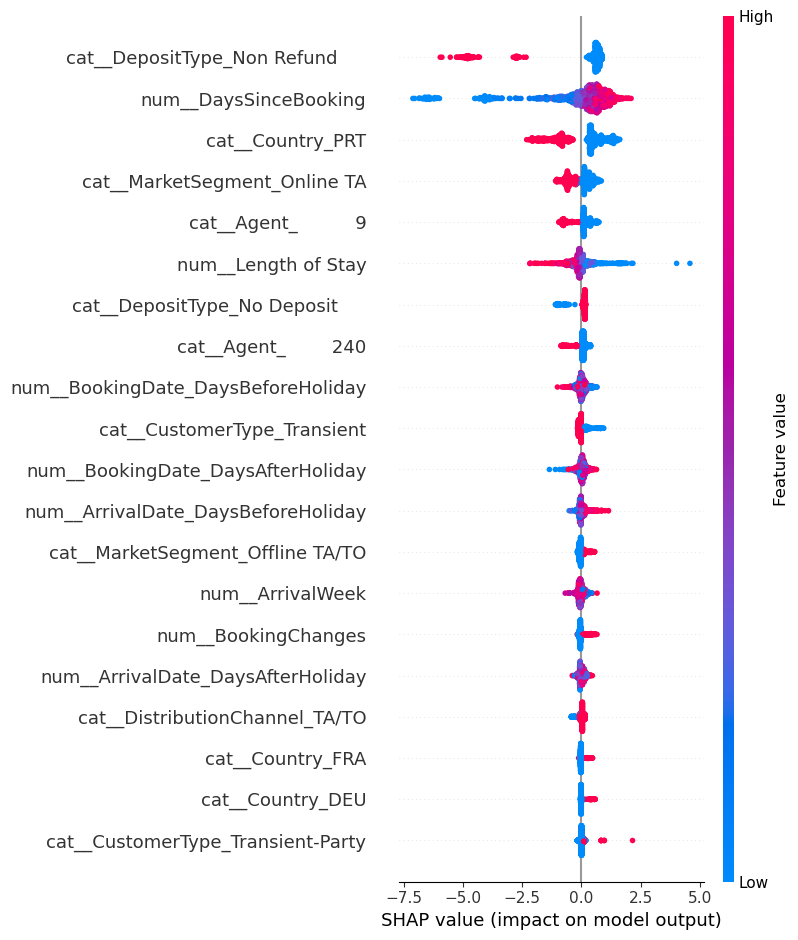

In [37]:
shap.summary_plot(shap_values, X_shap)

## ChatGPT-Suggested Improvements

In [38]:
# # Select categorical and numerical features
# cat_feats = X.select_dtypes(include=['object']).columns
# num_feats = X.select_dtypes(include=['number']).columns

# ## --- Create separate pipelines for categorical and numeric features --- ##

# # Create separate pipelines for categorical and numeric features
# cat_pipeline = Pipeline([
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('encoder', OneHotEncoder(handle_unknown='infrequent_if_exist',
#                               sparse_output=False,
#                               max_categories=200))
# ])

# num_pipeline = Pipeline([
#     ('imputer', SimpleImputer(strategy='mean')),
#     ('yeojohnson', PowerTransformer(method='yeo-johnson')),
#     ('scaler', StandardScaler())
# ])

# # Combine transformers into a single ColumnTransformer
# preprocessor = ColumnTransformer(transformers=[
#     ('num', num_pipeline, num_feats),
#     ('cat', cat_pipeline, cat_feats)
# ])

# # Create the RandomForestClassifier model
# classifier = HistGradientBoostingClassifier(class_weight='balanced',
#                                             scoring = 'f1_weighted')

# hgbr_model_pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('classifier', classifier)
# ])

# # Define the parameter grid for hyperparameter tuning
# param_grid = {
#     'classifier__learning_rate': [0.01, 0.1, 0.2],
#     'classifier__l2_regularization': [0, 0.1, 0.5],
# }

# # Set up Stratified K-Fold
# stratified_kfold = StratifiedKFold(n_splits=3, shuffle=False)

# # Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=hgbr_model_pipeline,
#                            param_grid=param_grid,
#                            cv=stratified_kfold,
#                            scoring='f1_weighted')

# # Fit the model with grid search
# with parallel_backend('loky', n_jobs=-1):
#     grid_search.fit(X_train, y_train)

# # Best parameters and score
# print("Best Parameters:", grid_search.best_params_)
# print("Best Score:", grid_search.best_score_)

# # Generate predictions and evaluate performance
# hgbr_y_pred = grid_search.predict(X_test)
# hgbr_score_training = grid_search.score(X_train, y_train)
# hgbr_score_testing = grid_search.score(X_test, y_test)

# print(f"Training Score: {hgbr_score_training}")
# print(f"Testing Score: {hgbr_score_testing}")